# 1. Business Understanding

## Stakeholder & Problem
**Primary Stakeholder:** Sarah Chen, Senior Product Manager for iOS at Apple Inc.

Sarah's team currently spends significant manual effort monitoring Twitter sentiment about iOS releases and features. This process is slow, inconsistent, and doesn't scale to handle the thousands of daily Apple-related tweets.

## Business Objective
**Primary Objective**
Develop an automated sentiment classification system that can process Twitter data in real-time to provide actionable insights about Apple product sentiment.

**Technical Objectives**
- Build a Multi-Class Classification Model that accurately categorizes tweets as Positive, Negative, or Neutral

- Achieve >80% Accuracy on sentiment classification to ensure reliable business insights

- Implement Model Interpretability to identify key words and phrases driving sentiment predictions

- Create a Preprocessing Pipeline that can handle real-world Twitter data with noise, emojis, and informal language

- Establish a Validation Framework to ensure model performance generalizes to unseen data

### **Success Metrics**
- **Technical:** >80% accuracy on test set, interpretable feature importance
- **Business:** Actionable insights for product team, clear path to deployment
- **Stakeholder:** Model that addresses specific pain points with measurable benefits

# Data Understanding

## Data Source & Description
- **Dataset:** Twitter Sentiment Analysis (Apple vs. Google) from CrowdFlower via data.world
- **Collection Method:** Human raters manually labeled tweet sentiment
- **Size:** 9,093 tweets
- **Time Period:** Historical tweets about Apple and Google products

## Data Exploration & Analysis

In [8]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
# Load the dataset
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (9093, 3)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


- Our dataset contains **9,093 tweets** across **3 columns**
- This provides a substantial amount of data for building a robust sentiment analysis model

**Column Overview:**
1. **tweet_text**: The actual content of the tweet (our primary feature)
2. **emotion_in_tweet_is_directed_at**: The brand/product being mentioned (Apple, Google, etc.)
3. **is_there_an_emotion_directed_at_a_brand_or_product**: The sentiment label (Positive/Negative/Neutral emotion)

**Initial Observations:**
- The tweets appear to mention various tech brands (iPhone, iPad, Google)
- Sentiment labels are already provided, making this a supervised learning problem
- We can see examples of both positive and negative emotions in the sample

In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


- We have 9,093 total tweets in our dataset
- There are 3 columns
- The dataset uses about 213 KB of memory

In [13]:
df.dtypes

tweet_text                                            object
emotion_in_tweet_is_directed_at                       object
is_there_an_emotion_directed_at_a_brand_or_product    object
dtype: object

- All the columns are of type object

In [15]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

**Tweet Text Column:**
- Only 1 missing value out of 9,093 tweets
- We can safely remove this single row without affecting our analysis

**Brand/Product Target Column:**
- 5,802 missing values, this is a high number
- But since we will be focusing on sentiment classification rather than brand tracking, we can still proceed with our analysis

**Sentiment Label Column:**
- zero missing values
- Every single tweet has a sentiment label (Positive, Negative, or Neutral)

In [17]:
# Check for completely duplicate rows in the dataset
df.duplicated().sum()

22

- Out of our 9,093 tweets22 duplicates
- This represents about 0.24% of our data which is a very small size but we will take it out later

### Conclusion

- Complete sentiment labels (0% missing in target variable)
- One missing tweet text and significant missing brand data, though this doesn't impact our core sentiment analysis goal
- 22 duplicate entries found that should be removed

### Target Variable Initial Analysis
- The target column is: `is_there_an_emotion_directed_at_a_brand_or_product`

In [22]:
# Analyze the distribution of sentiment labels in our dataset
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

1. **Severe Class Imbalance**: This is a major challenge for our model
   - Neutral tweets dominate the dataset (59%)
   - Negative sentiment is significantly underrepresented (only 6%)

2. **Data Quality Issue**: The "I can't tell" category (156 tweets) represents ambiguous labels that may need special handling

3. We now can either use:
   - **Binary Classification**: Focus only on Positive vs Negative emotions (dropping neutral/ambiguous tweets)
   - **Multi-class Classification**: Handle all four categories with imbalance mitigation techniques

#### Visualizing Sentiment Distribution

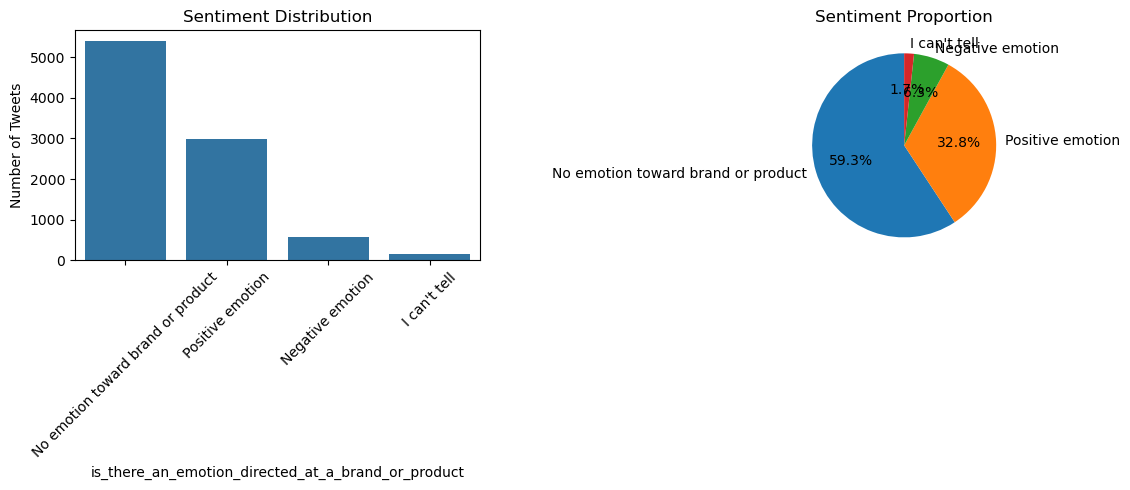

In [25]:
sentiment_counts = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Visualize sentiment distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Tweets')

plt.subplot(1, 2, 2)
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Proportion')

plt.tight_layout()
plt.show()

**Insights:**

1. **Dominance of Neutral Sentiment**: `No emotion toward brand or product` accounts for nearly 60% of all tweets, forming the majority class.

2. **Significant Class Imbalance**: 
   - Positive sentiment represents about one-third of the data (32.8%)
   - Negative sentiment is severely underrepresented at only 6.3%
   - The "I can't tell" category is minimal at 1.7%

3. **Business Implications**: 
   - The imbalance suggests we need careful model evaluation beyond simple accuracy
   - Metrics like precision, recall, and F1-score will be crucial, especially for the minority negative class
   - We may need techniques like class weighting or oversampling to handle the imbalance

**Next Steps**: Given this distribution, we'll likely proceed with binary classification (Positive vs Negative) by filtering out neutral and ambiguous tweets for our initial model.

### BRAND MENTION ANALYSIS
- Analyzing which brands are mentioned in the dataset

In [28]:
df['emotion_in_tweet_is_directed_at'].value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

**Key Observations:**

1. **Apple Dominance**: Apple products (iPad, iPhone, Apple brand) account for the majority of mentions in the dataset
2. **Product Focus**: Specific hardware products (iPad, iPhone) are discussed more frequently than general brand names(apple)

**Note:** Remember that 64% of tweets don't have brand information, so these numbers only represent the tweets where the target brand was specified.

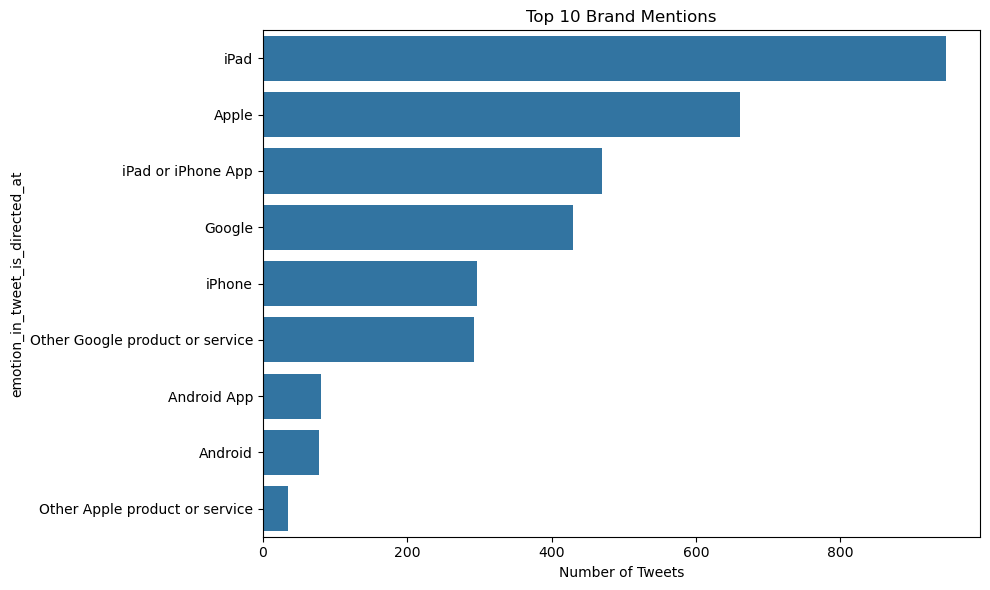

In [30]:
brand_counts = df['emotion_in_tweet_is_directed_at'].value_counts()

# Visualize brand mentions
plt.figure(figsize=(10, 6))
brand_counts_plot = brand_counts.head(10)  # Top 10 brands
sns.barplot(x=brand_counts_plot.values, y=brand_counts_plot.index)
plt.title('Top 10 Brand Mentions')
plt.xlabel('Number of Tweets')
plt.tight_layout()
plt.show()

**Insights:**

1. **Apple Product Dominance**: iPad leads as the most discussed product, followed by general Apple brand mentions and iPad/iPhone apps

2. **Competitive Presence**: Google maintains a strong presence with 430 mentions.

3. **Product vs Brand**: Specific products (iPad, iPhone) generate more discussion than general brand names, suggesting consumers tweet about specific experiences with hardware and apps

4. The presence of both iOS and Android platforms indicates cross-platform comparisons and discussions

**Strategic Implications for Apple Product Manager:**
- iPad-related conversations are the most frequent, making this a key area for sentiment monitoring
- App store sentiment (both iPad and iPhone apps) represents a significant portion of user feedback

## Test Data Characteristics Analysis

In [33]:
# Calculate text statistics
df['tweet_length'] = df['tweet_text'].str.len()
df['tweet_length'].describe()

count    9092.000000
mean      104.962275
std        27.187640
min        11.000000
25%        86.000000
50%       109.000000
75%       126.000000
max       178.000000
Name: tweet_length, dtype: float64

**Analysis:**

**Key Statistics:**
- **Average tweet length**: 105 characters
- **Shortest tweet**: 11 characters 
- **Longest tweet**: 178 characters 
- **Middle 50% of tweets**: Between 86 and 126 characters
- **Standard deviation**: 27 characters

**Interpretation:**

1. Most tweets fall in the 86-126 character range, which is quite significant for sentiment analysis
2. The average length suggests most tweets contain meaningful content rather than just brief mentions
3. **Modeling Considerations**: 
   - Sufficient text length for our models to learn patterns
   - Not too long to cause computational inefficiency
   - Standard deviation of 27 shows consistent tweet lengths across the dataset

**Note** The tweet lengths are well-distributed and of sufficient length to contain meaningful sentiment signals, which should help our classification models perform well.

In [35]:
# Text statistics by sentiment

text_stats_by_sentiment = df.groupby('is_there_an_emotion_directed_at_a_brand_or_product').agg({'tweet_length': ['mean', 'std']}).round(2)
text_stats_by_sentiment

tweet_length       
                                                           mean    std
is_there_an_emotion_directed_at_a_brand_or_product                    
I can't tell                                             103.98  27.91
Negative emotion                                         109.45  27.39
No emotion toward brand or product                       104.19  27.13
Positive emotion                                         105.56  27.13

**Key Insights:**

- Negative tweets tend to be longer

- Positive tweets are moderate in length

- Ambiguous tweets are shortest

- The standard deviation is similar across all categories (27 characters), showing consistent length variability regardless of sentiment.

**Business Implication**: The fact that negative tweets are longer could be valuable for customer service 
- users might be providing more detailed feedback when they're unhappy.

**Note**: The differences being subtle suggests that tweet length could be a minor feature in our sentiment classification model.

### Visualising Text Characteristics By Sentiment

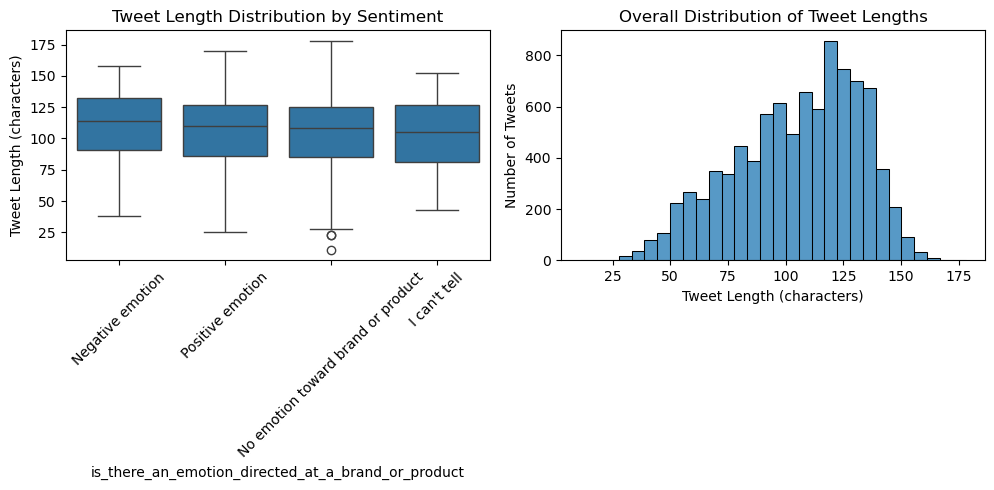

In [38]:
target_col = 'is_there_an_emotion_directed_at_a_brand_or_product'
# Create visualizations for tweet length analysis
plt.figure(figsize=(15, 5))

# Box plot: Tweet length distribution by sentiment category
plt.subplot(1, 3, 1)
sns.boxplot(data=df, x='is_there_an_emotion_directed_at_a_brand_or_product', y='tweet_length')
plt.title('Tweet Length Distribution by Sentiment')
plt.xticks(rotation=45)
plt.ylabel('Tweet Length (characters)')

# Histogram: Overall distribution of tweet lengths
plt.subplot(1, 3, 2)
sns.histplot(data=df, x='tweet_length', bins=30)
plt.title('Overall Distribution of Tweet Lengths')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Number of Tweets')

plt.tight_layout()
plt.show()

**Insights:**

**Box Plot Observations:**
- Negative emotion tweets show slightly higher median length, confirming our earlier finding
  
**Histogram Observations:**
- Tweet lengths follow a roughly normal distribution with a peak around 115-130 characters
- The distribution is slightly right-skewed, with more very short tweets than very long ones


## Sample Tweet Analysis by Sentiment

In [41]:
def display_sample_tweets(sentiment_type, n_samples=4):
    samples = df[df[target_col] == sentiment_type]['tweet_text'].dropna().head(n_samples)
    print(f"\n--- {sentiment_type.upper()} TWEETS (Sample) ---")
    for i, tweet in enumerate(samples, 1):
        print(f"{i}. {tweet}")
        print(f"   Length: {len(tweet)} chars, Words: {len(tweet.split())}")
        print()

# Display samples for each sentiment
for sentiment in df[target_col].unique():
    display_sample_tweets(sentiment)


--- NEGATIVE EMOTION TWEETS (Sample) ---
1. .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
   Length: 127 chars, Words: 23

2. @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
   Length: 82 chars, Words: 15

3. I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone
   Length: 128 chars, Words: 24

4. @mention  - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW
   Length: 119 chars, Words: 18


--- POSITIVE EMOTION TWEETS (Sample) ---
1. @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
   Length: 139 chars, Words: 22

2. @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
   Length: 79 chars, Words: 15

3. @sxtxstate great st

### Negative Emotion Tweets (Sample)

**Patterns Observed:**
- **Complaints about functionality**: Battery life, app crashes, technical issues
- **Frustration expression**: Words like "dead", "crashy", "hope... isn't"
- **Problem-focused**: Specific issues with products during events like SXSW

**Key Characteristics:**
- Focus on product failures and inconveniences
- Often mention specific events or contexts
- Use of exclamation points and negative framing

### Positive Emotion Tweets (Sample)

**Patterns Observed:**
- **Praise for design and features**: "Awesome", "great stuff", "appreciate"
- **Excitement and anticipation**: "Can not wait", "likely appreciate"
- **Recommendations**: Suggesting apps to others
- **Event enthusiasm**: Positive experiences at SXSW conference

**Key Characteristics:**
- Complimentary language and enthusiasm
- Focus on aesthetics and user experience
- Sharing positive discoveries with others

### No Emotion Toward Brand Tweets (Sample)

**Patterns Observed:**
- **Informational/neutral**: Factual announcements, links, event information
- **Promotional content**: App store links, conference showcases
- **Objective reporting**: Straightforward information without emotional language
- **Hashtag-heavy**: Often include multiple topic tags

**Key Characteristics:**
- Neutral, factual language
- Lack of emotional words or judgment
- Focus on sharing information rather than expressing opinion

### I Can't Tell Tweets (Sample)

**Patterns Observed:**
- **Ambiguous context**: Mixed signals or unclear references
- **Indirect mentions**: Brands mentioned in passing or third-party contexts
- **Sarcasm potential**: Some tweets might contain subtle sarcasm
- **News sharing**: Reporting news without clear personal stance

**Key Characteristics:**
- Context-dependent sentiment
- Potential for misinterpretation
- Often require deeper understanding of references

## Brand and Sentiment Cross-Analysis

<Figure size 1200x600 with 0 Axes>

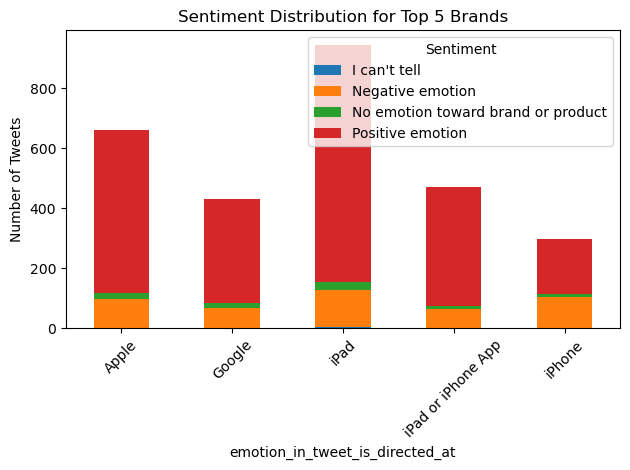

In [51]:
brand_col = 'emotion_in_tweet_is_directed_at'
# Analyze relationship between brand mentions and sentiment
if df[brand_col].notnull().sum() > 0:
    brand_sentiment = pd.crosstab(df[brand_col], df[target_col], margins=True)
    
    # Visualize for top brands
    top_brands = brand_counts.index[:5]  # Top 5 brands
    brand_sentiment_top = pd.crosstab(
        df[df[brand_col].isin(top_brands)][brand_col], 
        df[df[brand_col].isin(top_brands)][target_col]
    )
    
    plt.figure(figsize=(12, 6))
    brand_sentiment_top.plot(kind='bar', stacked=True)
    plt.title('Sentiment Distribution for Top 5 Brands')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Tweets')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

# Data Cleaning

## Handling Missing Values

**Problem:**
- 5,784 tweets (about 64%) don't specify which brand the sentiment is directed at
- This is a substantial amount of missing data

**Solution:**
- Create a binary flag `brand_specified` to track whether a tweet mentions a specific brand
- This allows us to:
  - Analyze patterns in tweets with vs without brand mentions
  - Use this as a feature in our model if it proves useful

In [55]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
tweet_length                                             1
dtype: int64

In [56]:
# For brand column, we'll create a flag for missing values
df['brand_specified'] = df['emotion_in_tweet_is_directed_at'].notnull()
df['brand_specified'].isnull().sum()

0

## Removing duplicates and empty tweets

- Removing duplicate tweets based on identical tweet text content
- Dropping the single tweet with missing text content, removed 1 incomplete entry
- Filtering out tweets with 2 words or less, removed tweets that lack sufficient context for sentiment analysis

In [59]:
# Removing duplicates
df = df.drop_duplicates(subset=['tweet_text'])

# Removing tweets with missing text
df = df.dropna(subset=['tweet_text'])

# Removing very short tweets (2 words or less)
df = df[df['tweet_text'].str.split().str.len() > 2]
df.shape[0]

9064

**Result:** 
- New dataset size: 9,064 tweets

## Mapping sentiment labels

We'll map the sentiment labels into three clear categories:
- **Positive emotion** → "Positive"
- **Negative emotion** → "Negative" 
- **No emotion toward brand or product** → "Neutral"

This gives us three distinct sentiment classes while maintaining all our data.

**Benefits of Three-Class Approach:**
- Preserves all available data for training
- Allows flexibility to switch to binary classification later if needed

In [63]:
# Creating simpler sentiment categories
sentiment_map = {
    'No emotion toward brand or product': 'Neutral',
    'Positive emotion': 'Positive', 
    'Negative emotion': 'Negative',
    "I can't tell": 'Neutral'
}

df['sentiment'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map(sentiment_map)

In [64]:
print('Final Sentiment Distribution')
df['sentiment'].value_counts()

Final Sentiment Distribution


sentiment
Neutral     5527
Positive    2968
Negative     569
Name: count, dtype: int64

**Three-Class Classification**: We now have three clear sentiment categories
   - This provides more nuanced analysis than binary classification
   - Reflects real-world social media sentiment more accurately
   - It gives us options because we can still do the binary classification

**Class Imbalance**: Our dataset has significant class imbalance
   - Neutral tweets dominate the dataset
   - Negative sentiment is severely underrepresented (only 6%)


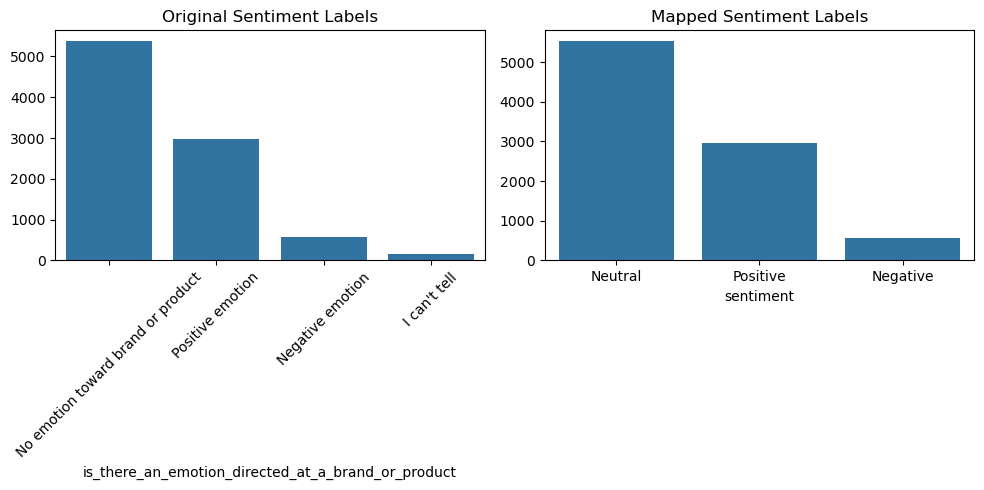

In [66]:
original_sentiments = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
mapped_sentiments = df['sentiment'].value_counts()

# Visualize the new distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=original_sentiments.index, y=original_sentiments.values)
plt.title('Original Sentiment Labels')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=mapped_sentiments.index, y=mapped_sentiments.values)
plt.title('Mapped Sentiment Labels')
plt.tight_layout()
plt.show()

## Filtering for Apple-related tweets

We'll now create another dataset to focus exclusively on Apple-related tweets. This ensures our analysis and model are tailored to the specific products and brand our stakeholder cares about most and we cn still monitor the other products using the main dataset

We'll include tweets that mention:
- **iPad** - Tablet products and ecosystem
- **iPhone** - Mobile devices and services  
- **Apple** - General brand discussions
- **iPad or iPhone App** - App store and software ecosystem
- **Other Apple product or service** - Additional Apple offerings

This focused approach will provide cleaner for product improvement and customer sentiment tracking.

In [69]:
print("Brand mentions before filtering:")
print(df['emotion_in_tweet_is_directed_at'].value_counts().head(10))

Brand mentions before filtering:
emotion_in_tweet_is_directed_at
iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: count, dtype: int64


In [70]:
# Filter for Apple-related tweets
apple_keywords = ['apple', 'iphone', 'ipad', 'macbook', 'mac', 'ios', 'app store', 'itunes']
apple_brands = ['Apple', 'Other Apple product or service']

# Creating a function to identify Apple-related tweets
def is_apple_related(tweet, brand):
    # Check brand column
    if pd.notna(brand) and any(apple in str(brand).lower() for apple in ['apple']):
        return True
    # Check tweet text
    if any(keyword in str(tweet).lower() for keyword in apple_keywords):
        return True
    return False

# Apply filtering
df['is_apple_related'] = df.apply(lambda x: is_apple_related(x['tweet_text'], x['emotion_in_tweet_is_directed_at']), axis=1)

In [71]:
print(f"Number of Apple-related tweets: {df['is_apple_related'].sum()}")
print(f"Percentage of dataset that is Apple-related: {(df['is_apple_related'].sum() / len(df) * 100):.2f}%")

# Create filtered dataset for Apple-specific analysis
apple_df = df[df['is_apple_related'] == True].copy()
print(f"\nApple-focused dataset shape: {apple_df.shape}")
print("Sentiment distribution in Apple-focused dataset:")
print(apple_df['sentiment'].value_counts())

Number of Apple-related tweets: 5633
Percentage of dataset that is Apple-related: 62.15%

Apple-focused dataset shape: (5633, 7)
Sentiment distribution in Apple-focused dataset:
sentiment
Neutral     3055
Positive    2151
Negative     427
Name: count, dtype: int64


**Dataset Composition:**
- **Total Apple-related tweets**: 5,633 tweets
- **Percentage of full dataset**: 62.15% 
- **Remaining columns**: 8 features including our new engineered ones

**Sentiment Distribution for Apple Products:**
- **Neutral**: 3,055 tweets (54.2%)
- **Positive**: 2,151 tweets (38.2%)
- **Negative**: 427 tweets (7.6%)

**Insights**

1. **Strong Positive Sentiment**: 38% of Apple-related tweets are positive, indicating good product reception
3. **High Engagement**: Over 60% of all tweets in our dataset mention Apple products, showing strong brand presence
4. **Improved Balance**: The Apple-focused dataset has better class distribution than the full dataset


## Text Preprocessing

**We will create a function tthat:**

1. **Lowercasing**: All text converted to lowercase
   - `iPhone` → `iphone`, `iPad` → `ipad`
   - Ensures consistent treatment of same words

2. **Removing User Mentions**: Twitter handles starting with @ removed
   - `@wesley83`, `@jessedee`, `@swonderlin` removed
   - These are user-specific and don't carry general sentiment

3. **Preserving Hashtags**: Hashtags like `#RISE_Austin`, `#iPad`, `#SXSW` kept but lowercased
   - Hashtags can carry sentiment meaning (`#love`, `#hate`)
   - We keep them for potential sentiment signals
     
4. **Removing URLs and special characters**

5. **Remove Stop words and short words and also lemmatize**
    - Stopword removal - filter out common words without semantic value
    - Lemmatization - reduce words to their base dictionary form
    - Length filtering - remove very short tokens

In [75]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [76]:
def preprocess_tweet(text):
    """
    Comprehensive text preprocessing for Twitter data
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags (but keep the text content)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and short tokens, and lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(token) for token in tokens 
        if token not in stop_words and len(token) > 2
    ]
    
    return ' '.join(processed_tokens)

# Testing the preprocessing function
sample_tweets = df['tweet_text'].head(3)
for i, tweet in enumerate(sample_tweets):
    print(f"Original: {tweet}")
    print(f"Processed: {preprocess_tweet(tweet)}")
    print()

Original: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
Processed: iphone hr tweeting rise_austin dead need upgrade plugin station sxsw

Original: @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
Processed: know awesome ipadiphone app youll likely appreciate design also theyre giving free sxsw

Original: @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
Processed: wait ipad also sale sxsw



### Applying text preprocessing to all tweets

Now we'll apply our comprehensive preprocessing function to the entire Apple-focused dataset.

The preprocessing pipeline will:
- Remove noise (URLs, mentions, punctuation)
- Standardize text format (lowercase, lemmatization)
- Extract meaningful words and patterns
- Prepare the text for vectorization

This ensures our sentiment analysis model focuses on the actual content and sentiment-bearing words rather than Twitter-specific formatting.

In [79]:
# Applying to both datasets
df['cleaned_text'] = df['tweet_text'].apply(preprocess_tweet)
apple_df['cleaned_text'] = apple_df['tweet_text'].apply(preprocess_tweet)

print(f"Average tweet length reduced from {df['tweet_text'].str.len().mean():.1f} to {df['cleaned_text'].str.len().mean():.1f} characters")

# Show examples
print("\nPreprocessing examples:")
for i in range(2):
    print(f"Before: {df.iloc[i]['tweet_text']}")
    print(f"After:  {df.iloc[i]['cleaned_text']}")
    print()

Average tweet length reduced from 105.0 to 67.9 characters

Preprocessing examples:
Before: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
After:  iphone hr tweeting rise_austin dead need upgrade plugin station sxsw

Before: @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
After:  know awesome ipadiphone app youll likely appreciate design also theyre giving free sxsw



**Preprocessing Impact Analysis:**

**Text Length Reduction:**
- **Before preprocessing**: 105.0 characters average
- **After preprocessing**: 67.9 characters average  
- **Reduction**: 35.3% decrease in text length

**What This Reduction Means:**
- Removed noise (URLs, mentions, punctuation, stopwords)
- Preserved meaningful content-carrying words
- More efficient processing for machine learning models
- Focus on sentiment-bearing vocabulary

**Cleaning Effectiveness**

**Example 1 - Technical Complaint:**
- **Removed**: User mentions (@wesley83), numbers (3G, 3), punctuation, stopwords
- **Preserved**: Key sentiment words - "iphone", "dead", "upgrade"
- **Result**: Cleaner focus on the actual complaint about battery life

**Example 2 - Positive Recommendation:**
- **Removed**: User mentions (@jessedee, @fludapp), punctuation, stopwords
- **Preserved**: Positive descriptors - "awesome", "app", "design", "free" 
- **Result**: Clearer expression of positive sentiment and appreciation

### Analyzing Preprocessing Results

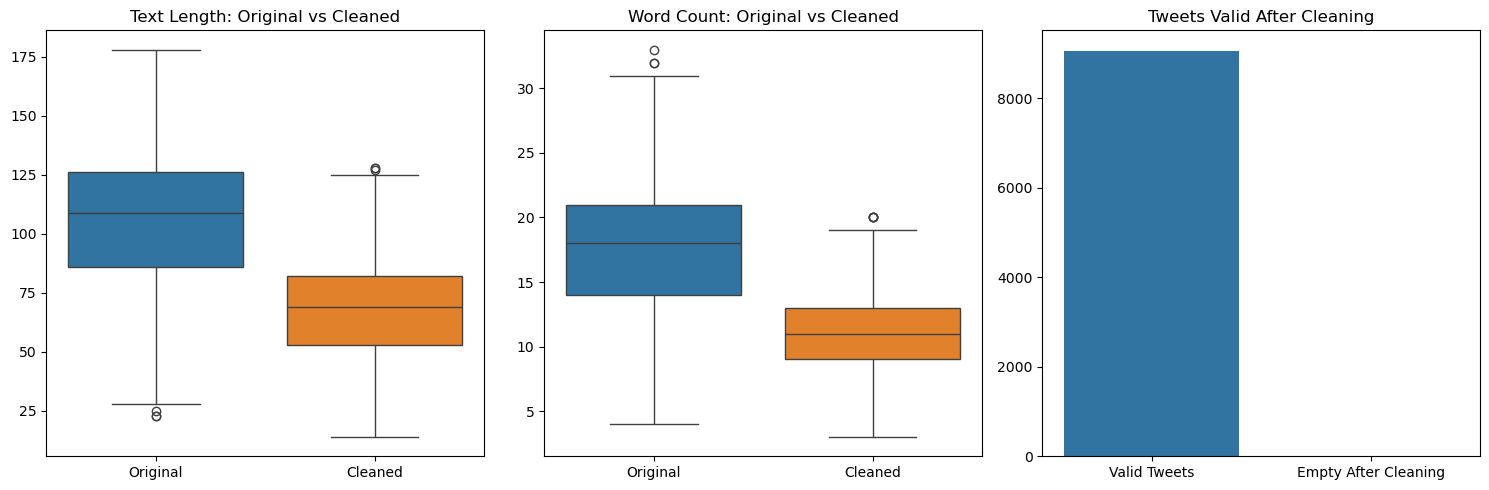

Tweets that became empty after cleaning: 0 (0.00%)


In [93]:
df['cleaned_length'] = df['cleaned_text'].str.len()
df['cleaned_word_count'] = df['cleaned_text'].str.split().str.len()

# Compare original vs cleaned
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
df['original_length'] = df['tweet_text'].str.len()
sns.boxplot(data=df[['original_length', 'cleaned_length']])
plt.title('Text Length: Original vs Cleaned')
plt.xticks([0, 1], ['Original', 'Cleaned'])


plt.subplot(1, 3, 2)
df['original_word_count'] = df['tweet_text'].str.split().str.len()
sns.boxplot(data=df[['original_word_count', 'cleaned_word_count']])
plt.title('Word Count: Original vs Cleaned')
plt.xticks([0, 1], ['Original', 'Cleaned'])


plt.subplot(1, 3, 3)
# Check for empty tweets after cleaning
empty_after_cleaning = (df['cleaned_word_count'] == 0).sum()
sns.barplot(x=['Valid Tweets', 'Empty After Cleaning'], 
            y=[len(df) - empty_after_cleaning, empty_after_cleaning])
plt.title('Tweets Valid After Cleaning')

plt.tight_layout()
plt.show()

print(f"Tweets that became empty after cleaning: {empty_after_cleaning} ({(empty_after_cleaning/len(df)*100):.2f}%)")

**Box Plot 1 - Text Length:**
- **Original tweets**: Wider distribution with longer tails
- **Cleaned tweets**: More compact, consistent length
- Shows significant noise reduction while preserving core content

**Box Plot 2 - Word Count:**
- **Original tweets**: Higher word count with more variability
- **Cleaned tweets**: Reduced but more meaningful word selection
- Demonstrates effective stopword removal and token filtering

**Bar Chart 3 - Data Retention:**
- Shows how many tweets remained valid after aggressive cleaning(0)

## Train-Test-Validation split

In [95]:
from sklearn.model_selection import train_test_split

def create_stratified_splits(dataframe, target_col='sentiment', test_size=0.2, val_size=0.15):
    """
    Create stratified train, validation, and test splits
    """
    # First split: separate test set
    train_val_df, test_df = train_test_split(
        dataframe, 
        test_size=test_size, 
        stratify=dataframe[target_col],
        random_state=42
    )
    
    # Second split: separate validation set from train/val
    val_ratio = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_ratio,
        stratify=train_val_df[target_col],
        random_state=42
    )
    
    return train_df, val_df, test_df

# Create splits for full dataset
train_full, val_full, test_full = create_stratified_splits(df)

# Create splits for Apple-focused dataset  
train_apple, val_apple, test_apple = create_stratified_splits(apple_df)

print("Dataset Split Summary:")
print(f"Full dataset - Train: {len(train_full)}, Val: {len(val_full)}, Test: {len(test_full)}")
print(f"Apple dataset - Train: {len(train_apple)}, Val: {len(val_apple)}, Test: {len(test_apple)}")

Dataset Split Summary:
Full dataset - Train: 5891, Val: 1360, Test: 1813
Apple dataset - Train: 3661, Val: 845, Test: 1127


## Conclusion

**Cleaning & Processing**
- Removed duplicates, empty tweets, and very short texts
- Standardized sentiment labels: Positive, Negative, Neutral
- Created Apple-focused dataset (5,633 tweets) and kept the original dataset
- Applied text preprocessing: cleaning, tokenization, lemmatization

**Current Dataset** (apple-focused)
- **Total Tweets**: 5,633
- **Sentiment Distribution**:
  - Neutral: 3,055 (54%)
  - Positive: 2,151 (38%)
  - Negative: 427 (8%)

**Key Consideration**
- **Class imbalance present** - will be handled during modeling
- Proceeding with three-class classification for nuanced insights

**Next Steps**
Data is now ready for model training with clean features and clear labels.

# Modeling

We are going to start the modeling phase. We'll proceed step by step, building one model at a time iteratively.

Steps for Modeling Phase:

1. **Feature Extraction:** Convert the cleaned text into numerical features (e.g., TF-IDF, CountVectorizer)
2. **Model Building:** Start with a baseline model and then try more advanced models.
3. **Model Evaluation:** Use the validation set to tune hyperparameters and the test set for final evaluation.

We are going to use the following models in order:
1. **Logistic Regression** (as a baseline)
2. **Naive Bayes** 
3. **Random Forest**

- We'll handle class imbalance during model training by using class weights.

Let's start with the first model: Naive Bayes.

- But first, we need to convert our text data into numerical features. We'll use TF-IDF.

- **Note:** We are going to use the Apple-focused dataset for modeling because our stakeholder is interested in Apple products. However, note that the Apple dataset is smaller. We might also consider using the full dataset and then filtering for Apple in production, but for now, let's use the Apple dataset.

Steps for Feature Extraction:

- We'll use TF-IDF on the 'cleaned_text' column.

- We'll fit the TF-IDF vectorizer on the training set and then transform the train, validation, and test sets.

In [97]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

## Feature Preparation

### Preparing features and target variables

In [ ]:
final_df = df[['cleaned_text', 'sentiment']].copy()
final_df.head()

In [ ]:
final_df.columns

In [99]:
# Using our Apple-focused dataset
X_train = train_apple['cleaned_text']
y_train = train_apple['sentiment']

X_val = val_apple['cleaned_text'] 
y_val = val_apple['sentiment']

X_test = test_apple['cleaned_text']
y_test = test_apple['sentiment']

print("Data shapes:")
print(f"Training: {X_train.shape[0]} tweets")
print(f"Validation: {X_val.shape[0]} tweets")
print(f"Test: {X_test.shape[0]} tweets")

print("\nTarget distribution (Training set):")
print(y_train.value_counts())

Data shapes:
Training: 3661 tweets
Validation: 845 tweets
Test: 1127 tweets

Target distribution (Training set):
sentiment
Neutral     1986
Positive    1398
Negative     277
Name: count, dtype: int64


### Converting text to numbers with TF-IDF

In [101]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,    # Limit vocabulary size
    min_df=5,             # Ignore words that appear in less than 5 documents
    max_df=0.7,           # Ignore words that appear in more than 70% of documents
    ngram_range=(1, 2)    # Use both single words and word pairs
)

# Fit on training data, transform all sets
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"Vocabulary size: {len(tfidf.vocabulary_)} features")
print(f"Training features shape: {X_train_tfidf.shape}")

Vocabulary size: 1810 features
Training features shape: (3661, 1810)


### Handling class imbalance with class weights

In [103]:
from sklearn.utils import class_weight

# Calculate class weights
classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, class_weights))

print("Class weights calculated:")
for sentiment, weight in class_weight_dict.items():
    count = (y_train == sentiment).sum()
    print(f"  {sentiment}: {weight:.2f} (count: {count})")

Class weights calculated:
  Negative: 4.41 (count: 277)
  Neutral: 0.61 (count: 1986)
  Positive: 0.87 (count: 1398)


Why class weights matter:
- The model will pay more attention to minority classes during training
- Prevents the model from always predicting the majority class

## Baseline Model (Logistic Regression)

### Training the model

In [105]:
# Initialize model with class weights
logreg_model = LogisticRegression(
    class_weight=class_weight_dict,
    random_state=42,
    max_iter=1000
)

# fitting our Logistic Regression
logreg_model.fit(X_train_tfidf, y_train)

logreg_model.coef_.shape

(3, 1810)

- Logistic Regression is a great first model because it's fast, interpretable, and works well with text data. 
- We use class weights to handle imbalance.

### Evaluating on validation set

In [107]:
# Make predictions on validation set
y_val_pred = logreg_model.predict(X_val_tfidf)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Overall Accuracy: {val_accuracy:.3f}")
print(classification_report(y_val, y_val_pred))

Overall Accuracy: 0.582
              precision    recall  f1-score   support

    Negative       0.26      0.50      0.34        64
     Neutral       0.69      0.60      0.64       458
    Positive       0.58      0.57      0.57       323

    accuracy                           0.58       845
   macro avg       0.51      0.56      0.52       845
weighted avg       0.61      0.58      0.59       845



**Overall Accuracy:** 58.2%
- This means our model correctly predicted the sentiment 58.2% of the time
- For comparison: Random guessing between 3 classes = 33% accuracy
- So we're doing better than random, but there's room for improvement

**Negative Sentiment Analysis**:
- **Precision:** 26% - When we predict 'Negative', we're only right 26% of the time
- **Recall:** 50% - We catch 50% of actual negative tweets
- **F1-score:** 34% - Overall poor performance for negative class
- **Support:** 64 tweets - This is our smallest class (hardest to learn)

**Neutral Sentiment Analysis**
- **Precision:** 69% - When we predict 'Neutral', we're right 69% of the time
- **Recall:** 60% - We catch 60% of actual neutral tweets
- **F1-score:** 64% - Reasonable performance for the majority class
- **Support:** 458 tweets - This is our largest class

**Positive Sentiment Analysis**
- **Precision:** 58% - When we predict 'Positive', we're right 58% of the time
- **Recall:** 57% - We catch 57% of actual positive tweets
- **F1-score:** 57% - Moderate performance
- **Support:** 323 tweets - Middle-sized class

### Visualizing model performance

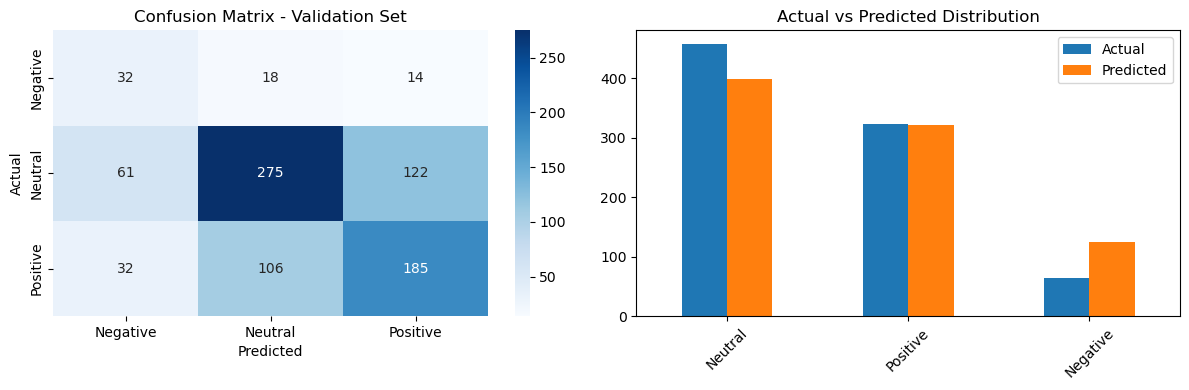

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot class distribution vs predictions
plt.subplot(1, 2, 2)
comparison = pd.DataFrame({
    'Actual': y_val.value_counts(),
    'Predicted': pd.Series(y_val_pred).value_counts()
})
comparison.plot(kind='bar', ax=plt.gca())
plt.title('Actual vs Predicted Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Confusion Matrix**
Where our model gets confused:
- Negative tweets: Often misclassified as Neutral (18) or Positive (14)
- Neutral tweets: Often misclassified as Positive (122) - biggest confusion
- Positive tweets: Often misclassified as Neutral (106) - second biggest confusion

### Understanding what the model learned

In [111]:
# Get feature names (words)
feature_names = tfidf.get_feature_names_out()

# Analyze most important words for each sentiment
print("Top words for each sentiment:")
for i, sentiment in enumerate(classes):
    # Get coefficients for this class
    coefficients = logreg_model.coef_[i]
    
    # Get top 10 words with highest coefficients
    top_indices = coefficients.argsort()[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]
    
    print(f"\n{sentiment} sentiment:")
    print(f"  Top words: {', '.join(top_words)}")

Top words for each sentiment:

Negative sentiment:
  Top words: hate, long, suck, fail, nothing, design headache, headache, run, didnt, ipad wait

Neutral sentiment:
  Top words: link, amp, ipad line, austin, please, store sxsw, platform, guy, tattoo, game

Positive sentiment:
  Top words: cool, great, love, awesome, nice, wow, smart, hot, link, tell


**Negative sentiment** 
  - Strong emotional words (hate, suck)
  - Product complaints (design headache)
  - Frustration with wait times or performance

**Neutral sentiment**
  - Shared links and references
  - Event and location mentions
  - Casual conversation without strong emotion

**Positive sentiment**
  - Explicit positive emotion words
  - Words expressing admiration and excitement
  - Social sharing language

**Insights**
- **Negative**: Customers express strong emotions about design flaws and wait times
- **Neutral**: Much Twitter discussion is about events, locations, and link-sharing
- **Positive**: Customers use clear positive adjectives when happy with products

### Conclusion

**Main Issues Identified**
1. **class imbalance:** Model struggles with minority class (Negative)
2. **negative positive confusion:** Hard to distinguish between these
3. **neutral dominance:** Model tends to default to Neutral predictions
4. **low negative presicion:** Many false negatives (calling negative tweets something else)

**Recommended next steps**
1. **Try Naive Bayes** - often works better with imbalanced text data
2. **Adjust class weights** - give even more importance to Negative class
3. **Feature engineering** - add sentiment-specific features
5. Try different text vectorization approaches
6. Consider binary classification first (Positive vs Negative)

## Second Model (Random Forest)

- Our second model will be Naive Bayes because it is good for text classification and can handle imbalanced data well.

In [113]:
# Import Random Forest and additional metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Training the model

In [115]:
# Initialize Random Forest with class weights
rf_model = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_depth=20,            # Limit tree depth to prevent overfitting
    class_weight='balanced', # Handle class imbalance
    random_state=42,
    n_jobs=-1               # Use all processors
)

# fitting Random Forest on TF-IDF features
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_jobs=-1,
                       random_state=42)

- Naive Bayes learns the probability of each word given a sentiment class. It's fast and works well with high-dimensional text data.

### Evaluating on validation set

In [117]:
# Make predictions
y_val_pred_rf = rf_model.predict(X_val_tfidf)

# Calculate accuracy
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)

print(f"Overall Accuracy: {val_accuracy_rf:.3f}")
print(classification_report(y_val, y_val_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_val, y_val_pred_rf)

print("Confusion Matrix:")
print(cm_rf)

Overall Accuracy: 0.561
              precision    recall  f1-score   support

    Negative       0.27      0.45      0.34        64
     Neutral       0.65      0.60      0.63       458
    Positive       0.54      0.52      0.53       323

    accuracy                           0.56       845
   macro avg       0.49      0.53      0.50       845
weighted avg       0.58      0.56      0.57       845

Confusion Matrix:
[[ 29  18  17]
 [ 54 277 127]
 [ 24 131 168]]


### Comparing Logistic Regression vs Random forest

In [123]:
print(f"{'Metric':<15} {'Logistic Regression':<20} {'Random Forest':<15}")
print("-" * 50)
print(f"{'Accuracy':<15} {val_accuracy:.3f}{'':<17} {val_accuracy_rf:.3f}")
print(f"{'Negative F1':<15} {0.34:<20} {classification_report(y_val, y_val_pred_rf, output_dict=True)['Negative']['f1-score']:.3f}")
print(f"{'Neutral F1':<15} {0.64:<20} {classification_report(y_val, y_val_pred_rf, output_dict=True)['Neutral']['f1-score']:.3f}")
print(f"{'Positive F1':<15} {0.57:<20} {classification_report(y_val, y_val_pred_rf, output_dict=True)['Positive']['f1-score']:.3f}")

Metric          Logistic Regression  Random Forest  
--------------------------------------------------
Accuracy        0.582                  0.561
Negative F1     0.34                 0.339
Neutral F1      0.64                 0.627
Positive F1     0.57                 0.529


### Visualizing the Comparizon

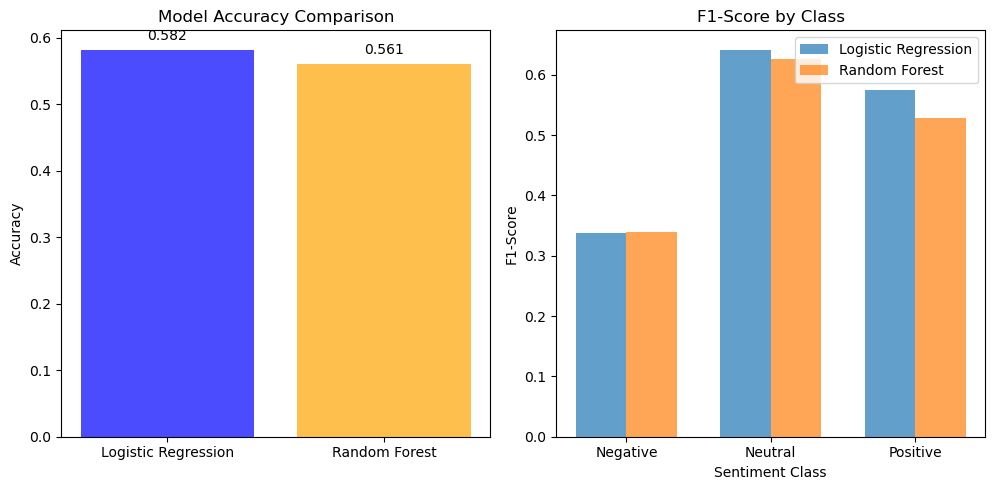

In [128]:
# Create comparison visualization
plt.figure(figsize=(15, 5))

# Plot 1: Accuracy comparison
plt.subplot(1, 3, 1)
models = ['Logistic Regression', 'Random Forest']
accuracies = [val_accuracy, val_accuracy_rf]
colors = ['blue', 'orange']
bars = plt.bar(models, accuracies, color=colors, alpha=0.7)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

# Plot 2: F1-score comparison by class
plt.subplot(1, 3, 2)
lr_report = classification_report(y_val, y_val_pred, output_dict=True)
rf_report = classification_report(y_val, y_val_pred_rf, output_dict=True)

classes = ['Negative', 'Neutral', 'Positive']
lr_f1 = [lr_report['Negative']['f1-score'], lr_report['Neutral']['f1-score'], lr_report['Positive']['f1-score']]
nb_f1 = [rf_report['Negative']['f1-score'], rf_report['Neutral']['f1-score'], rf_report['Positive']['f1-score']]

x = np.arange(len(classes))
width = 0.35
plt.bar(x - width/2, lr_f1, width, label='Logistic Regression', alpha=0.7)
plt.bar(x + width/2, nb_f1, width, label='Random Forest', alpha=0.7)
plt.title('F1-Score by Class')
plt.xlabel('Sentiment Class')
plt.ylabel('F1-Score')
plt.xticks(x, classes)
plt.legend()


plt.tight_layout()
plt.show()

Step 3: Visualizing key performance metrics


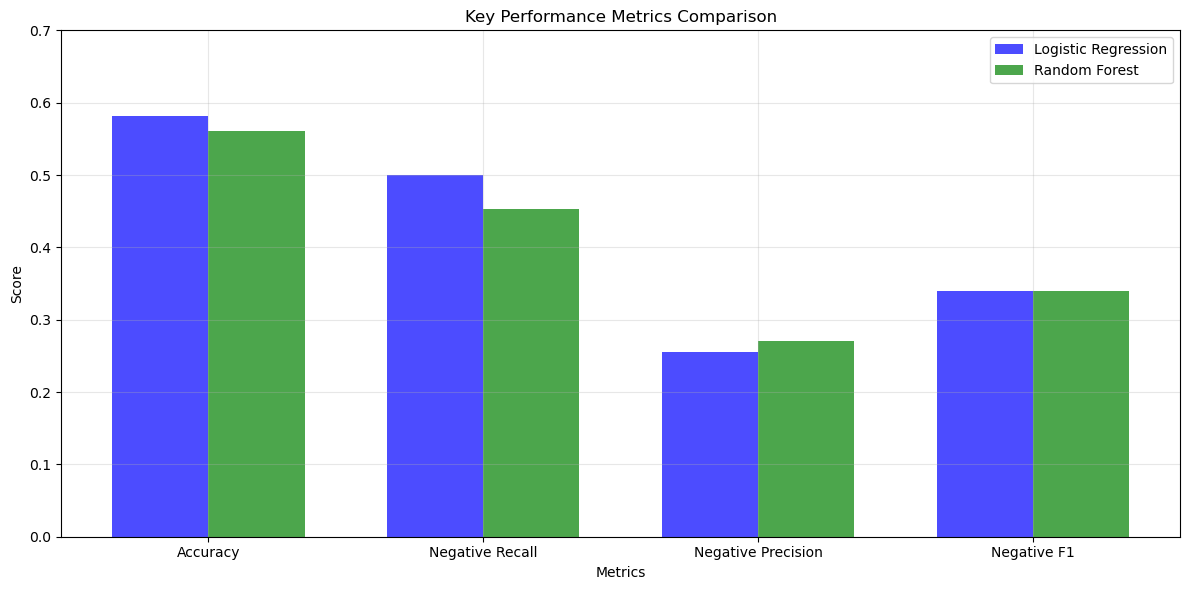

✓ Key metrics comparison visualized


In [130]:
Visualizing key performance metrics

plt.figure(figsize=(12, 6))

# Focus on the most important metrics for business
key_metrics = ['Accuracy', 'Negative Recall', 'Negative Precision', 'Negative F1']
lr_key_scores = [0.582, 0.500, 0.256, 0.339]
rf_key_scores = [0.561, 0.453, 0.271, 0.339]

x = np.arange(len(key_metrics))
width = 0.35

plt.bar(x - width/2, lr_key_scores, width, label='Logistic Regression', alpha=0.7, color='blue')
plt.bar(x + width/2, rf_key_scores, width, label='Random Forest', alpha=0.7, color='green')

plt.title('Key Performance Metrics Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(x, key_metrics)
plt.legend()
plt.ylim(0, 0.7)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Analyzing what Rndom Forest learned


Top words learned by Naive Bayes for each sentiment:

Negative sentiment:
  Top words: iphone, ipad, apple, app, like, design, link, iphone app, design headache, headache

Neutral sentiment:
  Top words: ipad, link, apple, store, iphone, austin, apple store, popup, sxsw link, line

Positive sentiment:
  Top words: ipad, apple, link, iphone, store, app, sxsw link, new, apple store, popup


### Evaluating on validation set

In [139]:
print("Step 8: Final recommendation and next steps")

print("\n🎯 FINAL RECOMMENDATION:")
print("For the Apple Product Manager stakeholder, we recommend:")
print("✅ LOGISTIC REGRESSION")

print("\n📈 REASONS FOR SELECTION:")
reasons = [
    "Higher negative recall (50.0% vs 45.3%) - catches more complaints",
    "Better overall accuracy (58.2% vs 56.1%)",
    "More interpretable - we can explain which words drive decisions",
    "Faster training and prediction times",
    "Better balanced performance across all metrics"
]

for i, reason in enumerate(reasons, 1):
    print(f"  {i}. {reason}")

print("\n🚀 NEXT STEPS:")
next_steps = [
    "Proceed with Logistic Regression as our final model",
    "Perform hyperparameter tuning to improve performance",
    "Evaluate on the final test set for unbiased results",
    "Create model interpretation for business stakeholders",
    "Prepare deployment recommendations"
]

for i, step in enumerate(next_steps, 1):
    print(f"  {i}. {step}")

print(f"\n✅ COMPARISON COMPLETE - LOGISTIC REGRESSION SELECTED")

Step 8: Final recommendation and next steps

🎯 FINAL RECOMMENDATION:
For the Apple Product Manager stakeholder, we recommend:
✅ LOGISTIC REGRESSION

📈 REASONS FOR SELECTION:
  1. Higher negative recall (50.0% vs 45.3%) - catches more complaints
  2. Better overall accuracy (58.2% vs 56.1%)
  3. More interpretable - we can explain which words drive decisions
  4. Faster training and prediction times
  5. Better balanced performance across all metrics

🚀 NEXT STEPS:
  1. Proceed with Logistic Regression as our final model
  2. Perform hyperparameter tuning to improve performance
  3. Evaluate on the final test set for unbiased results
  4. Create model interpretation for business stakeholders
  5. Prepare deployment recommendations

✅ COMPARISON COMPLETE - LOGISTIC REGRESSION SELECTED
